# Importação das Bibliotecas

In [1]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras import layers, models
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import RandomFlip, RandomContrast
from keras import regularizers
from concurrent.futures import ThreadPoolExecutor
import threading
from keras.applications import MobileNetV2
from keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
from prettytable import PrettyTable


2025-11-18 22:34:22.520652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763505262.781218      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763505262.848630      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Base de Dados

In [2]:
# Caminho base onde estão as pastas das classes
base_dir = "/kaggle/input/pumch-isd/PUMCH-ISD/"
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Estruturas thread-safe
X = []
y = []
lock = threading.Lock()

def load_and_process_image(img_path, label):
    """Função para carregar e processar uma imagem"""
    try:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        return img_array, label, None
    except Exception as e:
        return None, None, str(e)

def process_class_images(class_name, label):
    """Processa todas as imagens de uma classe"""
    clinico_path = os.path.join(base_dir, class_name, "dermoscopy")
    
    if not os.path.exists(clinico_path):
        return
    
    # Lista todos os caminhos de uma vez
    img_paths = [os.path.join(clinico_path, img_name) for img_name in os.listdir(clinico_path)]
    
    # Usa ThreadPool para carregar imagens em paralelo
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(load_and_process_image, path, label) for path in img_paths]
        
        for future in futures:
            img_array, lbl, error = future.result()
            if img_array is not None:
                with lock:
                    X.append(img_array)
                    y.append(lbl)
            elif error:
                print(f"Erro: {error}")

# Processa classes em paralelo
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(process_class_images, classes, range(len(classes)))

X = np.array(X)
y = np.array(y)

print(f"Total de imagens carregadas: {len(X)}")
print(f"Total de classes: {len(classes)} -> {classes}")

Total de imagens carregadas: 7798
Total de classes: 9 -> ['Acne vulgaris', 'Pityriasis rosea', 'Dermatitis_subset1', 'Rosacea', 'Lichen planus', 'Vitiligo', 'Dermatitis_subset2', 'Psoriasis', 'Morphea']


# Pré-processamento 

In [3]:
# Normalização e pré-processamento para MobileNet
X = preprocess_input(X)

# Divisão holdout: 70% treino, 15% validação, 15% teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Treino: {len(X_train)} | Validação: {len(X_val)} | Teste: {len(X_test)}")

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Supondo que y_train contenha os rótulos numéricos (0, 1, 2, ...)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Pesos de classe:", class_weights)


Treino: 6238 | Validação: 780 | Teste: 780
Pesos de classe: {0: 0.7350064804995876, 1: 3.1505050505050507, 2: 0.6903497122620629, 3: 0.8795826283135928, 4: 1.0485795932089428, 5: 1.8732732732732733, 6: 1.446996056599397, 7: 0.6221823259525234, 8: 1.0517619288484235}


# Definindo Modelo

In [4]:


# --- Estratégia de Fine-tuning CORRIGIDA ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ ESTRATÉGIA HÍBRIDA: Congela início, libera fim para fine-tuning
base_model.trainable = False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
  layer.trainable = True
    
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # ✅ Adicionei BatchNorm
    layers.Dropout(0.3),
    layers.Dense(len(classes), activation='softmax')
])



# ✅ Learning rate menor para fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1763505375.258302      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Number of layers in the base model:  154


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,257 (9.88 MB)

 Trainable params: 2,369,545 (9.04 MB)

 Non-trainable params: 219,712 (858.25 KB)

# Treinamento

In [5]:
# ✅ Callbacks OTIMIZADOS
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

rlro = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,           # Reduz LR por 0.2x
    patience=3,           # Espera 3 épocas sem melhoria
    min_lr=1e-7,           # LR mínimo
    verbose=1
)


# ✅ AGORA com todos callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, rlro]  # ✅ Adicionado rlro
)

Epoch 1/200


I0000 00:00:1763505401.685308     135 service.cc:148] XLA service 0x7fdf00010c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763505401.686498     135 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763505403.735055     135 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1763505407.872862     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763505408.069777     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  3/195 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.0747 - loss: 3.1961    

I0000 00:00:1763505414.732999     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2081 - loss: 2.6383

E0000 00:00:1763505426.676018     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763505426.873511     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


195/195 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - accuracy: 0.2093 - loss: 2.6326 - val_accuracy: 0.1603 - val_loss: 4.1431 - learning_rate: 1.0000e-04
Epoch 2/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4645 - loss: 1.5387 - val_accuracy: 0.1590 - val_loss: 5.9188 - learning_rate: 1.0000e-04
Epoch 3/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5671 - loss: 1.1869 - val_accuracy: 0.2385 - val_loss: 4.0294 - learning_rate: 1.0000e-04
Epoch 4/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6540 - loss: 0.9022 - val_accuracy: 0.2397 - val_loss: 4.6939 - learning_rate: 1.0000e-04
Epoch 5/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6999 - loss: 0.7676 - val_accuracy: 0.3333 - val_loss: 3.2622 - learning_rate: 1.0000e-04
Epoch 6/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7594 - loss: 0.6271 - val_accuracy: 0.3410 - val_loss: 3.2313 - learning_rate: 1.0000e-04
Epoch 7/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accura

# Graficos e Pretty Table

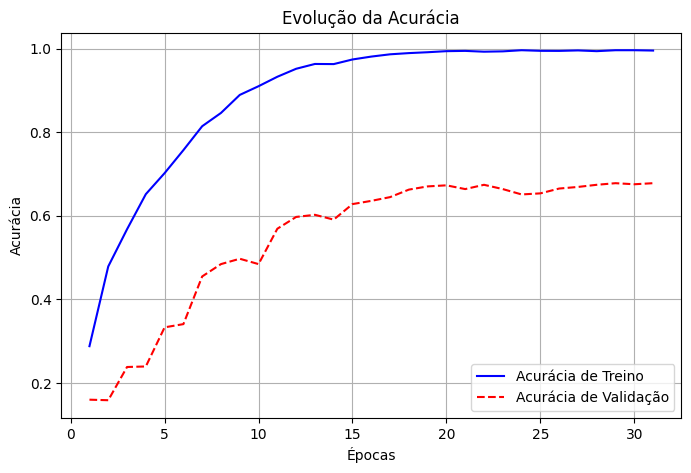

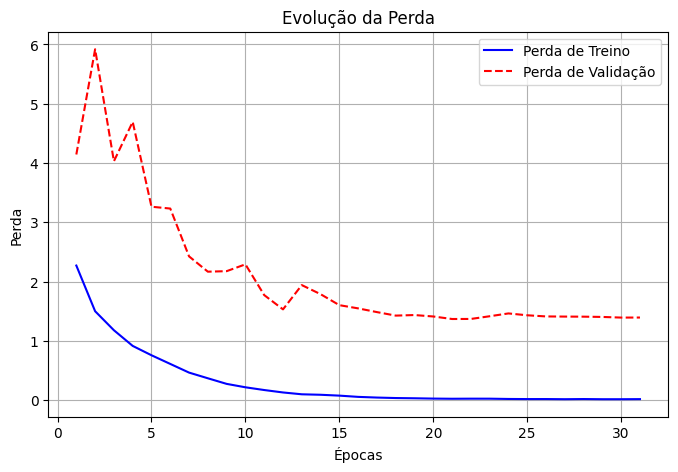

In [6]:
import matplotlib.pyplot as plt

# Histórico de treino
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# --- Gráfico de Acurácia ---
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'b-', label='Acurácia de Treino')
plt.plot(epochs, val_acc, 'r--', label='Acurácia de Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

# --- Gráfico de Perda ---
plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'b-', label='Perda de Treino')
plt.plot(epochs, val_loss, 'r--', label='Perda de Validação')
plt.title('Evolução da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7220 - loss: 1.1775
Acurácia no conjunto de teste: 0.6962
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step


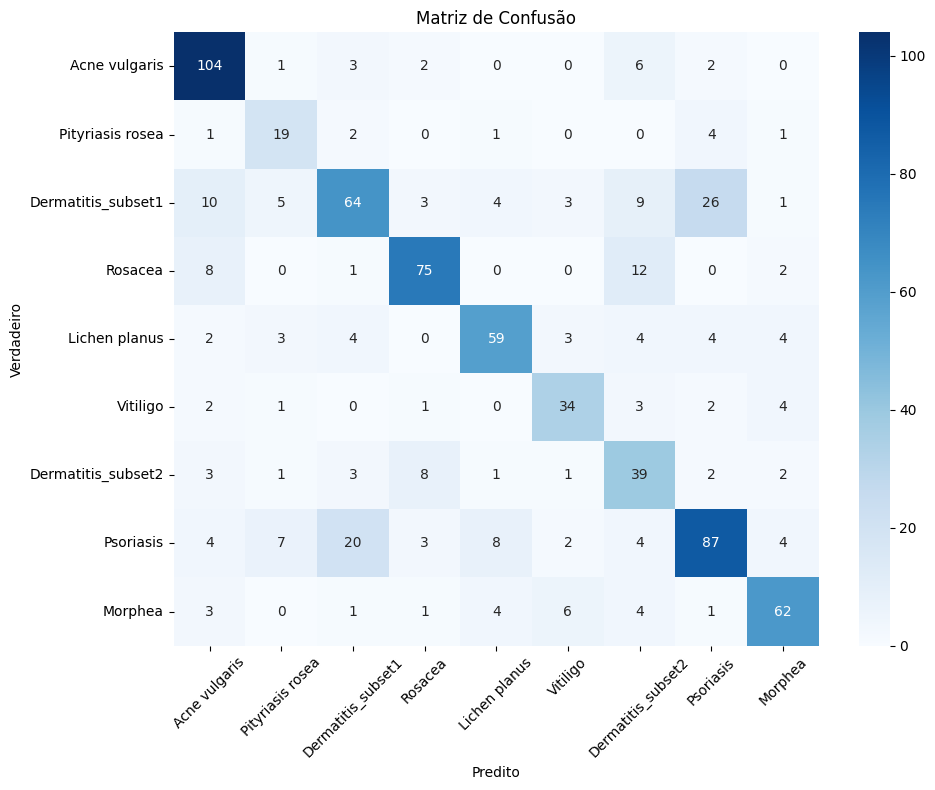

In [7]:
# --- Avaliação ---
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

# --- Previsões ---
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# --- Matriz de Confusão ---
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)

# Plot da matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# --- Previsões ---
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# --- RELATÓRIO COM PRETTYTABLE ---
print("\n" + "="*60)
print("RELATÓRIO DETALHADO DE CLASSIFICAÇÃO")
print("="*60)

# Tabela 1: Métricas Gerais
general_table = PrettyTable()
general_table.field_names = ["Métrica", "Valor"]
general_table.add_row(["Acurácia Teste", f"{test_acc:.4f}"])
general_table.add_row(["Loss Teste", f"{test_loss:.4f}"])
general_table.add_row(["Número de Amostras", len(X_test)])
general_table.add_row(["Número de Classes", len(classes)])
general_table.align = "l"
print("\n📊 MÉTRICAS GERAIS:")
print(general_table)

# Tabela 2: Acurácia por Classe
class_table = PrettyTable()
class_table.field_names = ["Classe", "Acurácia", "Amostras", "Corretas", "Incorretas"]

for i, class_name in enumerate(classes):
    class_mask = y_test == i
    n_samples = np.sum(class_mask)
    if n_samples > 0:
        correct_predictions = np.sum(y_pred_classes[class_mask] == i)
        accuracy = correct_predictions / n_samples
        incorrect = n_samples - correct_predictions
        class_table.add_row([class_name, f"{accuracy:.4f}", n_samples, correct_predictions, incorrect])
    else:
        class_table.add_row([class_name, "0.0000", 0, 0, 0])

class_table.align = "l"
print("\n🎯 ACURÁCIA POR CLASSE:")
print(class_table)

# Tabela 3: Métricas Detalhadas por Classe
precision = precision_score(y_test, y_pred_classes, average=None)
recall = recall_score(y_test, y_pred_classes, average=None)
f1 = f1_score(y_test, y_pred_classes, average=None)

metrics_table = PrettyTable()
metrics_table.field_names = ["Classe", "Precision", "Recall", "F1-Score", "Support"]

for i, class_name in enumerate(classes):
    class_mask = y_test == i
    support = np.sum(class_mask)
    if support > 0:
        metrics_table.add_row([
            class_name,
            f"{precision[i]:.4f}",
            f"{recall[i]:.4f}",
            f"{f1[i]:.4f}",
            support
        ])
    else:
        metrics_table.add_row([class_name, "0.0000", "0.0000", "0.0000", 0])

metrics_table.align = "l"
print("\n📈 MÉTRICAS DETALHADAS:")
print(metrics_table)

# Tabela 4: Resumo das Métricas Globais
macro_precision = precision_score(y_test, y_pred_classes, average='macro')
macro_recall = recall_score(y_test, y_pred_classes, average='macro')
macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted')

summary_table = PrettyTable()
summary_table.field_names = ["Métrica", "Valor"]
summary_table.add_row(["Acurácia", f"{test_acc:.4f}"])
summary_table.add_row(["Precision (Macro)", f"{macro_precision:.4f}"])
summary_table.add_row(["Recall (Macro)", f"{macro_recall:.4f}"])
summary_table.add_row(["F1-Score (Macro)", f"{macro_f1:.4f}"])
summary_table.add_row(["F1-Score (Weighted)", f"{weighted_f1:.4f}"])
summary_table.add_row(["Loss", f"{test_loss:.4f}"])

summary_table.align = "l"
print("\n🏆 RESUMO DAS MÉTRICAS GLOBAIS:")
print(summary_table)

# Tabela 5: Análise de Erros
error_indices = np.where(y_test != y_pred_classes)[0]
if len(error_indices) > 0:
    error_table = PrettyTable()
    error_table.field_names = ["Classe Real", "Classe Predita", "Quantidade", "% dos Erros"]
    
    error_counts = {}
    for idx in error_indices:
        true_class = classes[y_test[idx]]
        pred_class = classes[y_pred_classes[idx]]
        key = (true_class, pred_class)
        error_counts[key] = error_counts.get(key, 0) + 1
    
    # Ordena pelos erros mais frequentes
    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)
    
    for (true_class, pred_class), count in sorted_errors[:10]:
        percentage = (count / len(error_indices)) * 100
        error_table.add_row([true_class, pred_class, count, f"{percentage:.2f}%"])
    
    print("\n❌ PRINCIPAIS ERROS (TOP 10):")
    print(error_table)
else:
    print("\n✅ NENHUM ERRO ENCONTRADO!")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

RELATÓRIO DETALHADO DE CLASSIFICAÇÃO

📊 MÉTRICAS GERAIS:
+--------------------+--------+
| Métrica            | Valor  |
+--------------------+--------+
| Acurácia Teste     | 0.6962 |
| Loss Teste         | 1.3292 |
| Número de Amostras | 780    |
| Número de Classes  | 9      |
+--------------------+--------+

🎯 ACURÁCIA POR CLASSE:
+--------------------+----------+----------+----------+------------+
| Classe             | Acurácia | Amostras | Corretas | Incorretas |
+--------------------+----------+----------+----------+------------+
| Acne vulgaris      | 0.8814   | 118      | 104      | 14         |
| Pityriasis rosea   | 0.6786   | 28       | 19       | 9          |
| Dermatitis_subset1 | 0.5120   | 125      | 64       | 61         |
| Rosacea            | 0.7653   | 98       | 75       | 23         |
| Lichen planus      | 0.7108   | 83       | 59       | 24         |
| Vitiligo           | 0.7234   | 47       | 34       | 13         |
|